# Data Science Essentials: GeoPandas
    Caelan Osman
    Math 403, Sec. 1
    Sep. 21, 2021

In [39]:
! pip install geopandas
from google.colab import files
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

## Problem 1

Read in the file *airports.csv* as a pandas dataframe.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates to a *shapely.geometry.Polygon* object.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport
	
Create a new GeoDataFrame with these three Polygons as entries.
Plot this GeoDataFrame on top of an outlined world map.

In [5]:
# upload airport.csv
airports = files.upload()

Saving airports.csv to airports.csv


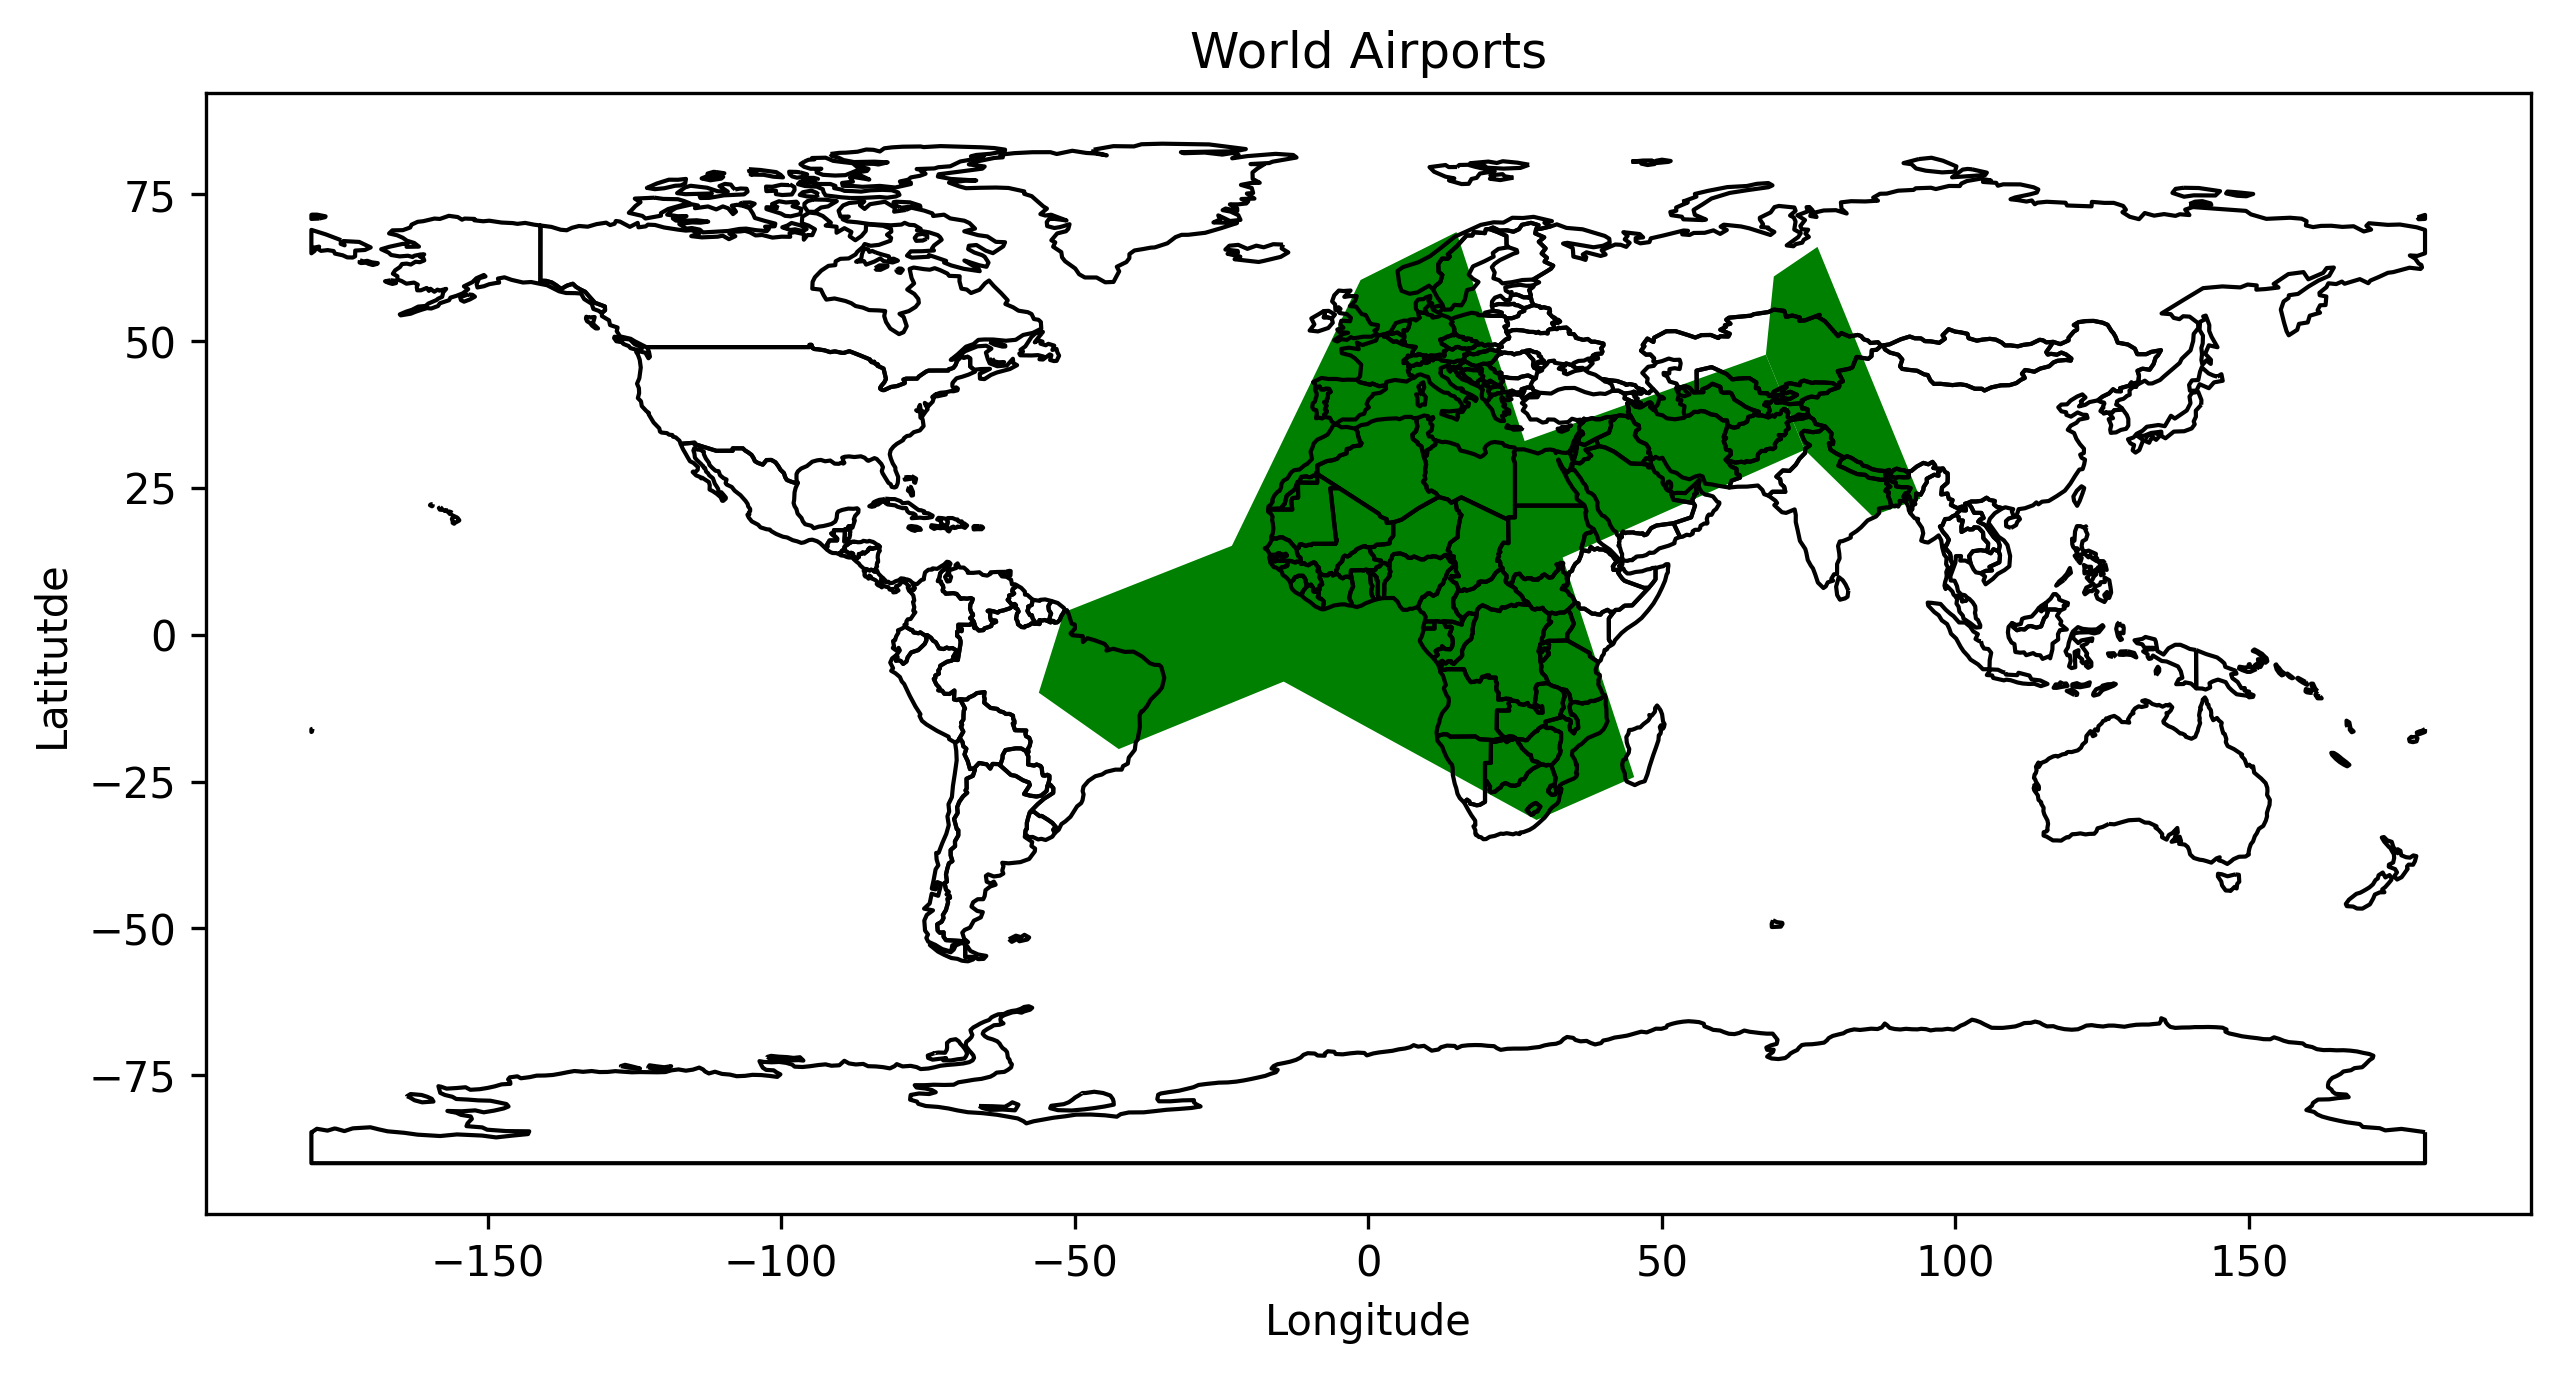

In [22]:
#define sets for the convex hull
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']
#read in data
df = pd.read_csv('airports.csv', delimiter=',', header=0, index_col='Name')

#get the polygons
first_polygon = Polygon(list(zip(df.loc[first_set].Longitude,
                                 df.loc[first_set].Latitude)))
second_polygon = Polygon(list(zip(df.loc[second_set].Longitude, 
                                  df.loc[second_set].Latitude)))
third_polygon = Polygon(list(zip(df.loc[third_set].Longitude, 
                                 df.loc[third_set].Latitude)))

#create GeoDataFrame with the three polygons above
gdf = gpd.GeoDataFrame({'cities' :['first_set', 'second_set', 'third_set'],
                        'geometry': [first_polygon, second_polygon, third_polygon]
                        })

#get world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig,ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1)
fig.set_dpi(300)
base = world.boundary.plot(edgecolor='black', ax=ax, linewidth=1)
gdf.plot(ax=base, marker='o', color='green', markersize=1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitutde')
ax.set_title('World Airports')
plt.show()

## Problem 2
Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the outlines of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines all counties within a single state.
Drop states with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

In [7]:
# upload county.gpkg.zip
county = files.upload()
!unzip county_data.gpkg.zip
county_df = gpd.read_file('county_data.gpkg')

Saving county_data.gpkg.zip to county_data.gpkg.zip
Archive:  county_data.gpkg.zip
   creating: county_data.gpkg/
 extracting: county_data.gpkg/county_data.cpg  
  inflating: county_data.gpkg/county_data.dbf  
  inflating: county_data.gpkg/county_data.prj  
  inflating: county_data.gpkg/county_data.shp  
  inflating: county_data.gpkg/county_data.shx  


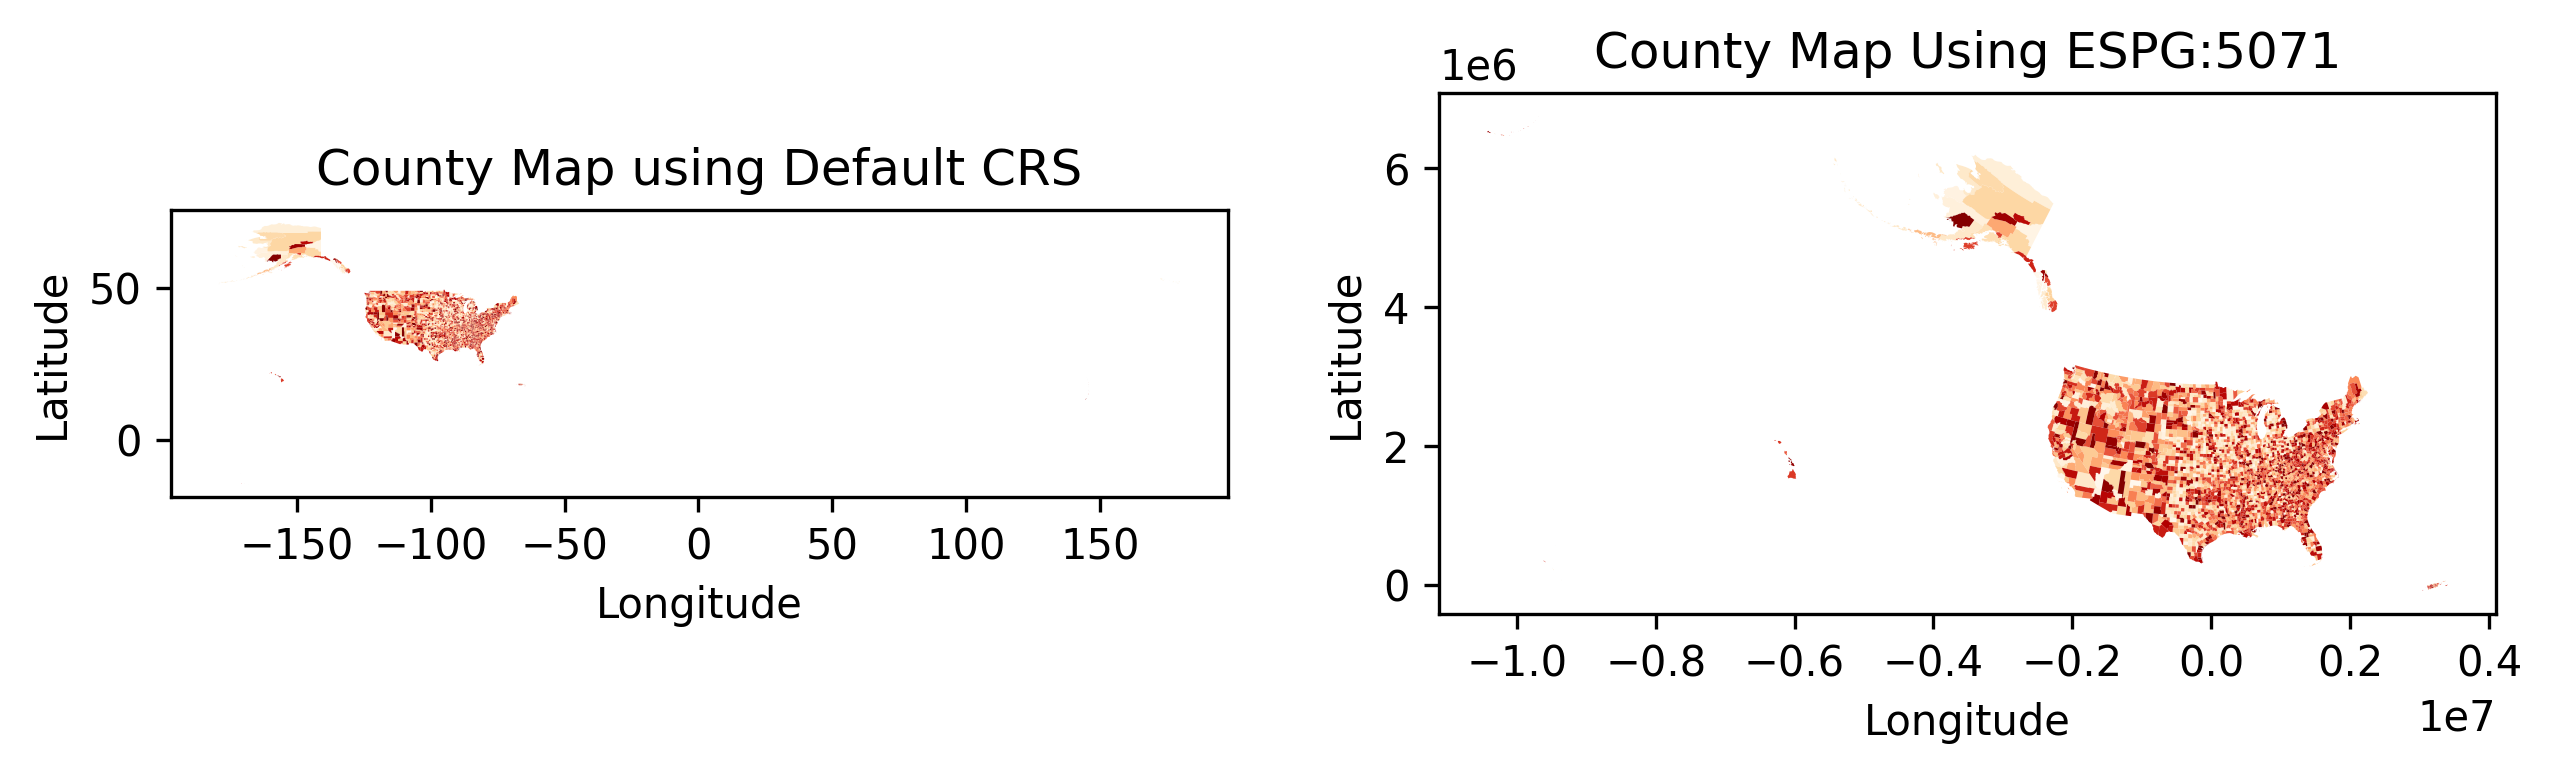

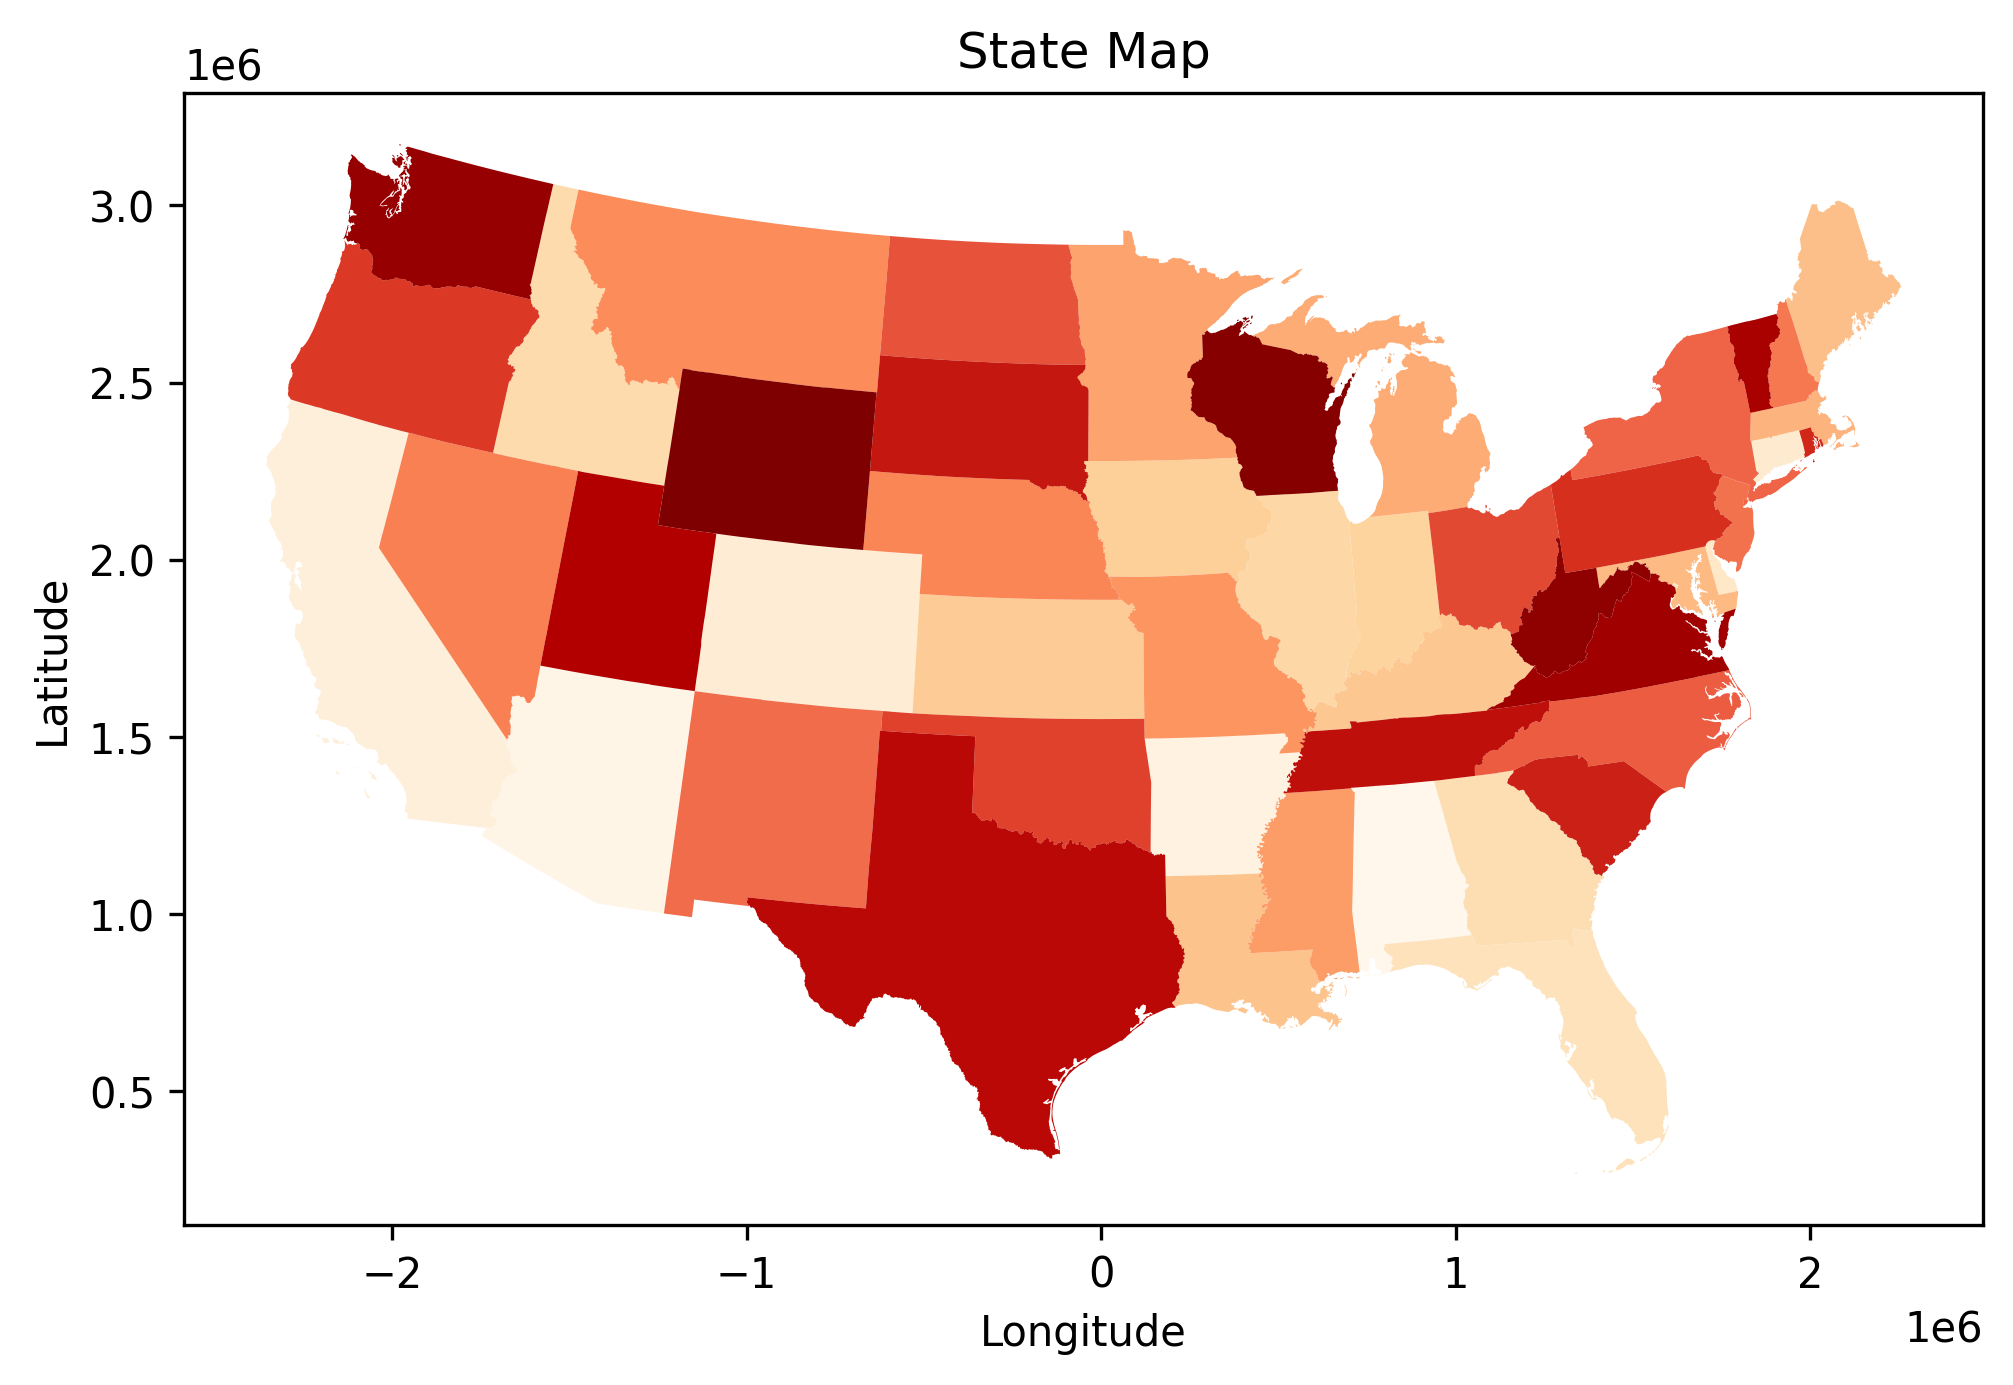

In [21]:
#read in data 
county_gdf = gpd.read_file('county_data.gpkg')
#create plot
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
fig.set_dpi(300)
county_gdf.plot( cmap='OrRd', ax=ax[0])
ax[0].set_title('County Map using Default CRS')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
#change crs type and replot
county_gdf.to_crs(5071, inplace=True)
county_gdf.plot( cmap='OrRd', ax=ax[1])
ax[1].set_title('County Map Using ESPG:5071')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.show() 

#create new dataframe for state and drop desired values
state = county_gdf.dissolve(by='STATEFP').drop(['02', '15', '60', '66', '69','72', '78'])
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
fig.set_dpi(300)
state.plot(cmap='OrRd', ax=ax)
ax.set_title('State Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

## Problem 3

Load in the file *nytimes.csv* as a DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.
**First, convert the *date* column into a *DatetimeIndex*.**

Next, use county FIPS codes to **merge your GeoDataFrame from the previous problem with the DataFrame you just created.**
A FIPS code is a 5-digit unique identifier for geographic locations.
For this lab, we will ignore rows in the Covid-19 DataFramw tih unknown FIPS codes.
Also, we will just be examining data from the contiguous US, so **drop all data from Hawaii and Alaska.**

Note that the *fips* column of the Covid-19 DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three in the *COUNTYFP* column.

**Plot the cases from March 21, 2020 on top of your state outline map from the previous problem.
Finally, print out the name of the county with the most cases along with its case count.**

In [10]:
ny = files.upload()

Saving nytimes.csv to nytimes.csv


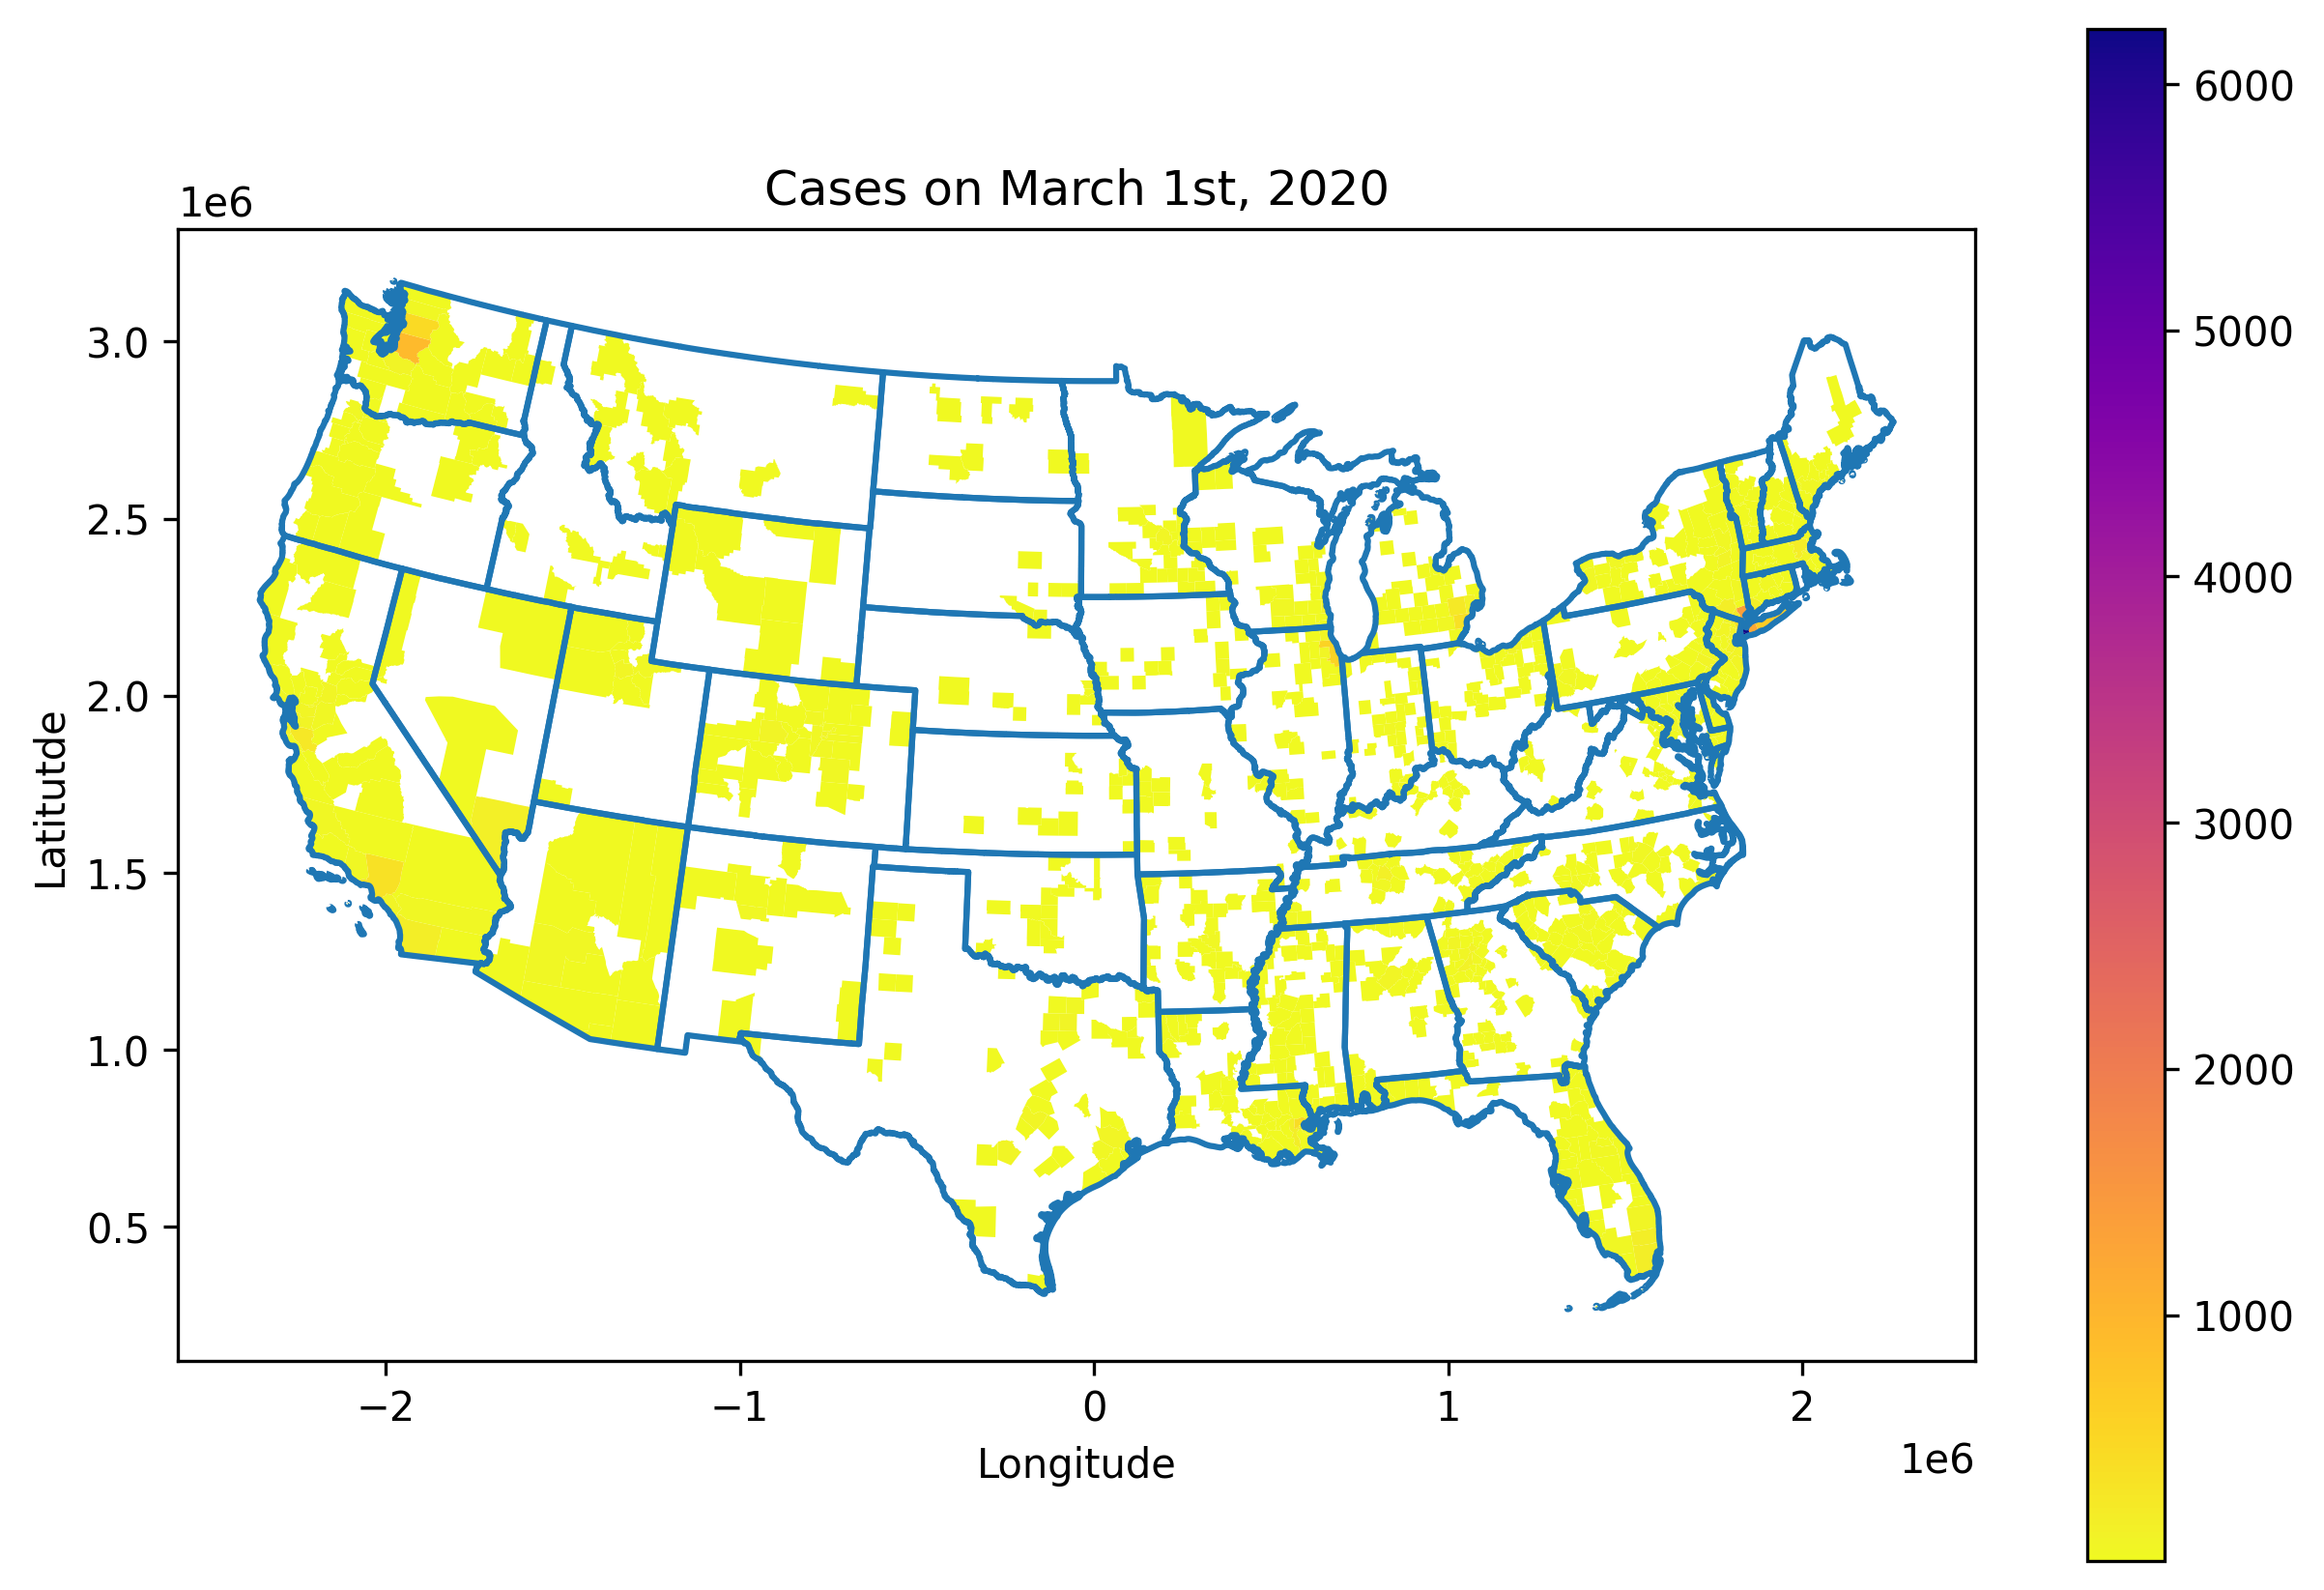

New York City
6226


In [20]:
#add fips to the county_gdf data frame
county_gdf['fips'] = county_gdf['STATEFP']+county_gdf['COUNTYFP']
county_gdf['fips'] = county_gdf['fips'].astype(float)
#load in dataframe


df = pd.read_csv('nytimes.csv', delimiter=',')
#add date time index
df['date'] = pd.to_datetime(df['date'])
#add geometry to dataframe
df = df.set_index('state')
df = df.drop(['Hawaii', 'Alaska'])

#merge dataframes
counties = county_gdf.merge(df, on='fips')
#grab the data
case = counties.loc[counties['date'] == '2020-03-21']

#set up plot
fig, ax = plt.subplots(figsize=(10, 7), ncols=1, nrows=1)
fig.set_dpi(300)
base = state.boundary.plot(ax=ax)

#plot the cases
case.plot(column='cases', cmap='plasma_r', ax=ax, legend=True)
ax.set_title('Cases on March 1st, 2020')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitutde')
plt.show()

case.set_index('county', inplace=True)
index = case['cases'].idxmax()
print(index)
print(case.loc[index].cases[0])

## Problem 4

As in Problem 3, plot your state outline map together with a map of Covid-19 cases from March 21, 2020.
This time, use a log scale.
Use EPSG:5071.
Pick a good colormap and be sure to display a colorbar.

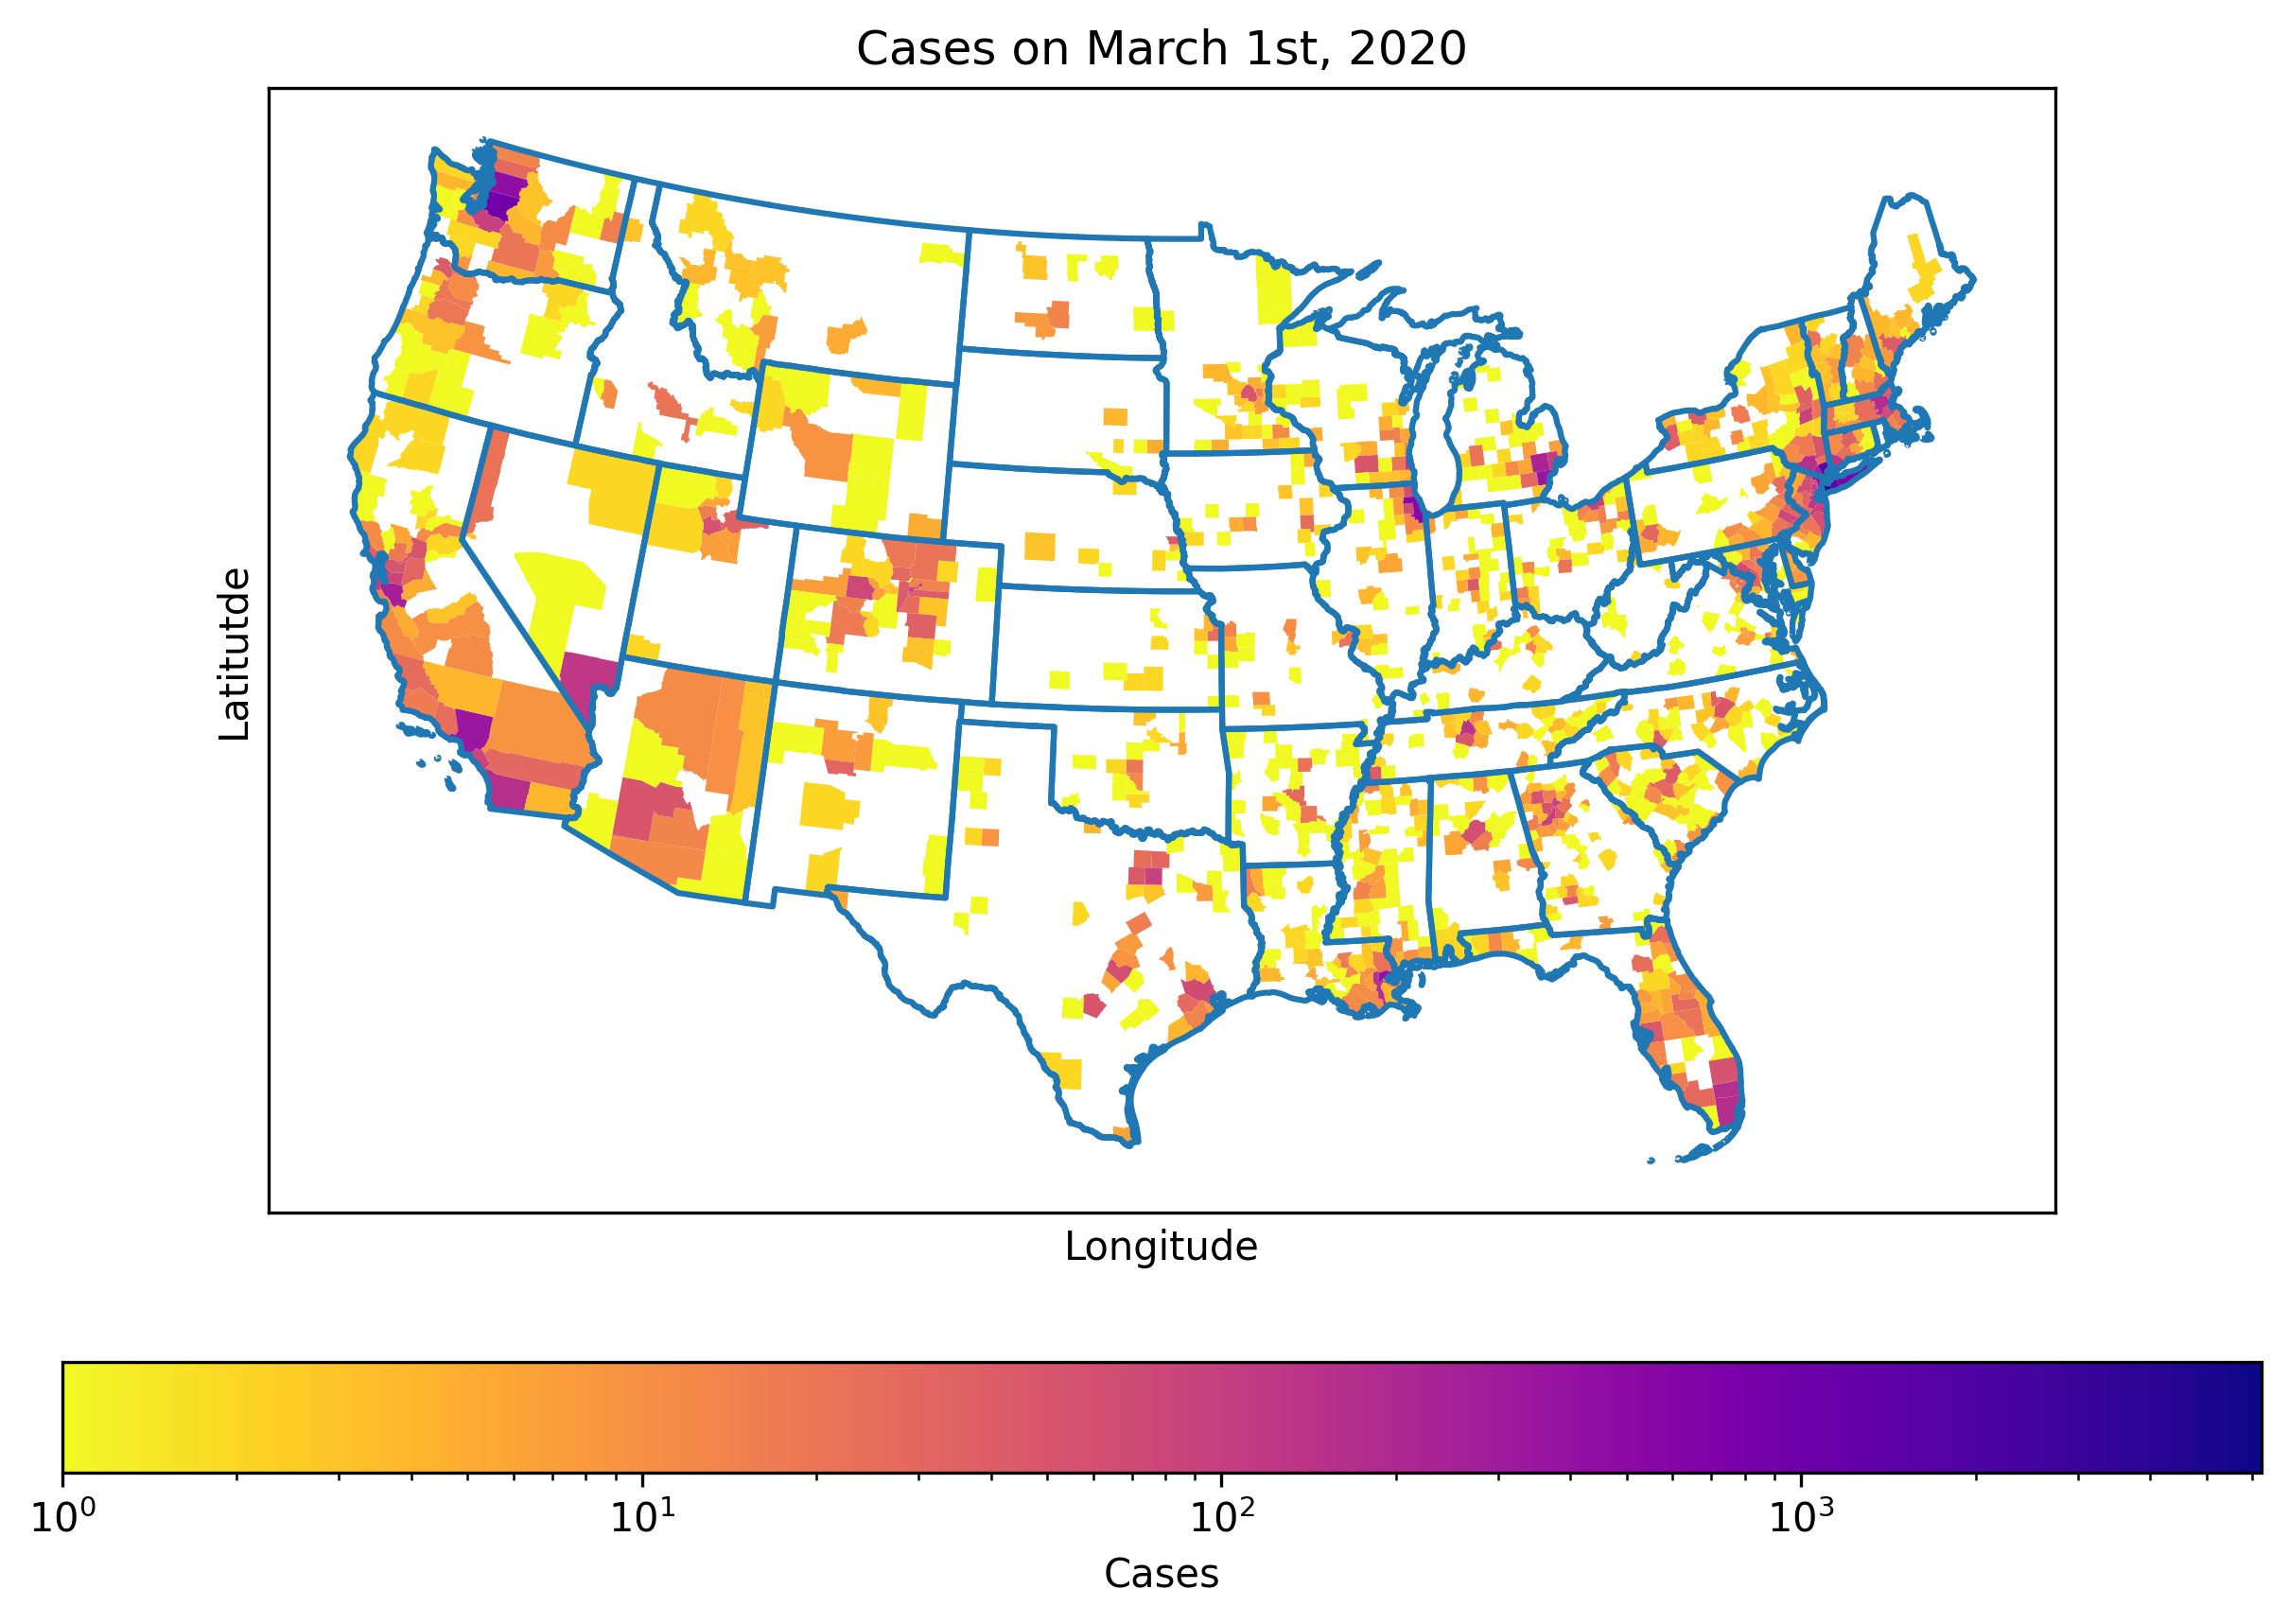

In [19]:
#create figure
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7))
fig.set_dpi(300)
#plot base
base = state.boundary.plot(ax=ax)
#set norm for the log scale
data = case.cases
norm = LogNorm(vmin = min(data), vmax=max(data))
#plot the cases
case.plot(column='cases', cmap='plasma_r', ax=ax, norm=norm)
#plot color bar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='plasma_r'), 
                    ax=ax, orientation='horizontal', 
                    pad=0.1, label='Cases' )
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Cases on March 1st, 2020')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitutde')
plt.show()

## Problem 5
In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020 to June 21, 2020.
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.
Use EPSG:5071 for the CRS.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your vmax so that the scale remains uniform.
- Write your update function. This should plot the cases from a given day.
- Set up your colorbar. Do this outside the update function to avoid adding a new colorbar each day.
- Create the animation. Check to make sure everything displays properly before you save it.
- Save the animation.
- Display the animation.

In [ ]:
#Set up figure and norm
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 5))
base = state.boundary.plot(ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Covid 19 Spread')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitutde')

#set norm for the log scale
max_case = counties.max()['cases']
min_case = counties.min()['cases']
norm = LogNorm(vmin=min_case, vmax=max_case)

def update(date):
    #Plot the cases from a single day
    case = counties.loc[counties['date'] == date]
    case.plot(column='cases', cmap='plasma_r', ax=ax, norm=norm)
    return
    
#Set up the colorbar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='plasma_r'), 
                    ax=ax, orientation='horizontal', 
                    pad=0.1, label='Cases' )

#Create the animation
animation.writer = animation.writers['ffmpeg']
plt.ioff()
#set frames from january to june with daily frequency
frame = pd.date_range(start='1/21/2020', end='6/21/2020', freq='D')
ani = animation.FuncAnimation(fig, update, 
                              frames=frame, 
                              interval=100)
ani.save('covid_19.mp4')

<video src="covid_19.mp4" controls>